## Clustering segment level model data for creating segment profiles
### Authors: Shreya Pandit, Ben Batorsky, Jenny Turner-Trauring

### Importing required packages 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sys
sys.path.append("../src/")
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pandas.io.json import json_normalize #package for flattening json in pandas df



%matplotlib inline

### Loading dataframe used in modeling 

In [2]:
city = 'boston'

In [3]:
df = pd.read_csv('../data/{}/processed/seg_with_predicted.csv'.format(city))

In [4]:
df.head()

,segment_id,lanes,hwy_type,osm_speed,width_per_lane,AADT,width,cycleway_type,signal,oneway,...,F_F_Class5,F_F_Class7,log_lanes,log_hwy_type,log_osm_speed,log_width_per_lane,log_AADT,intersection,target,prediction
0,0,2,1,0,15,18330,30,0,0,0,...,0,1,1.098612,0.693147,0.000000,2.772589,9.816349,1,0,0.381185
1,0,2,1,25,8,0,15,0,0,0,...,0,1,1.098612,0.693147,3.258097,2.197225,0.000000,0,0,0.407151
2,1,2,2,0,15,22222,30,0,0,1,...,0,0,1.098612,1.098612,0.000000,2.772589,10.008883,0,1,0.490905
3,10,3,2,0,8,8974,24,1,0,1,...,0,0,1.386294,1.098612,0.000000,2.197225,9.102198,0,1,0.751227
4,100,2,3,25,8,0,17,0,0,1,...,0,1,1.098612,1.386294,3.258097,2.197225,0.000000,0,1,0.736244


### Selecting a subset of columns which we will use in further analysis

In [5]:
city_columns = {'boston':['AADT', 'SPEEDLIMIT', 'Struct_Cnd', 
                          'Surface_Tp', 'F_F_Class', 'visionzero', 
                          'Conflict', 'intersection'],
               'cambridge':['lanes', 'hwy_type', 'osm_speed', 'oneway',
                           'signal', 'seeclickfix', 'width'],
                'dc':['lanes', 'hwy_type', 'osm_speed', 'oneway',
                           'signal']}

In [6]:
df_minimal_columns = df[city_columns[city]].fillna(0)

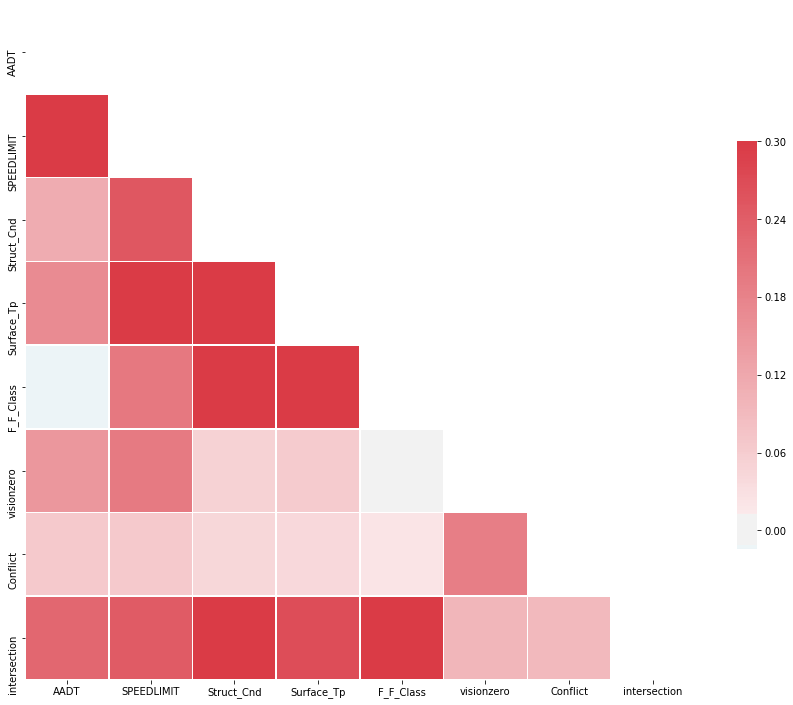

In [7]:
corr = df_minimal_columns.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [8]:
#df_minimal_columns

### Apply PCA

In [9]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [10]:
df_input = df_minimal_columns.fillna(0)
pca = PCA(n_components=4,random_state=12345)
# make pipeline
pipe = make_pipeline(StandardScaler(), pca)
pipe.fit(df_input)
pca_result = pipe.fit_transform(df_input)


In [11]:
def pca_results(good_data, pca):
# adapted from: https://github.com/viktortnk/udacity-ml/blob/master/projects/creating_customer_segments/renders.py
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (16,10))

	# Plot the feature weights as a function of the components
	colors = ['r','g','b','y','m','k','c']*2
	components.plot(ax = ax, kind = 'bar', color=colors)
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,AADT,SPEEDLIMIT,Struct_Cnd,Surface_Tp,F_F_Class,visionzero,Conflict,intersection
Dimension 1,0.3543,0.2277,0.3306,0.4937,0.5036,0.4641,0.1087,0.0768,0.3292
Dimension 2,0.1921,0.5777,0.4740,-0.2382,-0.2120,-0.3452,0.3923,0.2348,0.1084
Dimension 3,0.1344,-0.3517,-0.2828,0.0430,0.0037,0.0616,0.4872,0.7429,0.0363
Dimension 4,0.1016,-0.1052,0.0673,0.0676,0.1662,0.0554,0.6717,-0.4473,-0.5458


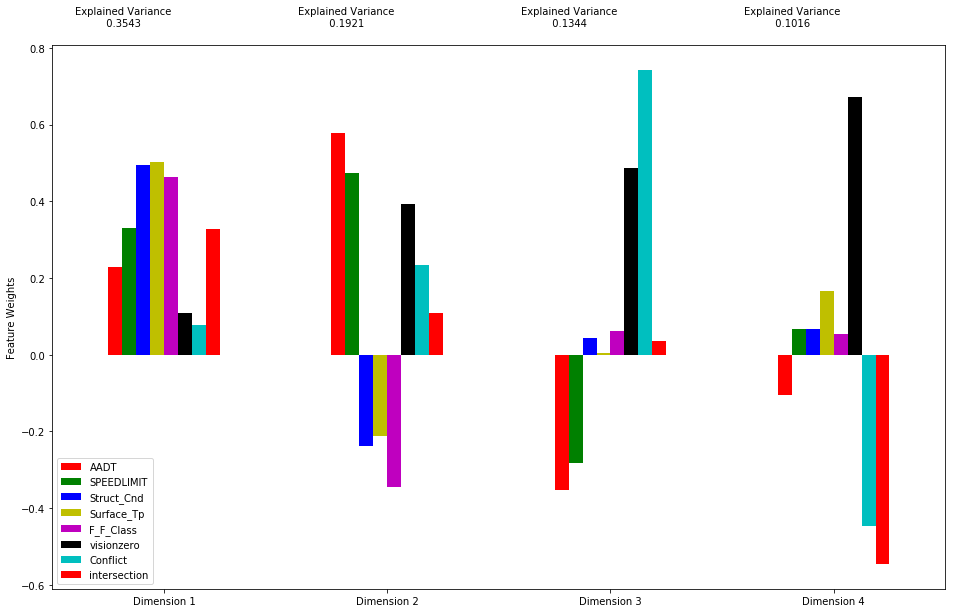

In [12]:
pca_results(df_input, pipe.named_steps.pca)

### High risk (red) and Non high risk segments plotted
High risk = Prediction above a threshold.  Here I use 75 to more clearly indicate highest risk

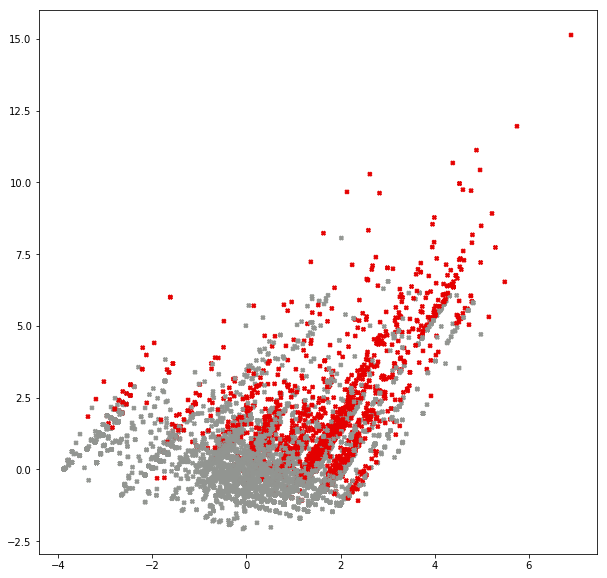

In [13]:
plt.figure(figsize=[10,10])
color_mapping = {False: sns.xkcd_rgb['grey'], True: sns.xkcd_rgb['red']}
colors = list(map(lambda x: color_mapping[x], df.prediction>.75))
plt.scatter(
        pca_result[:,0],
        pca_result[:,1],
        s=16,
        marker="X", c = colors)

# Applying KMeans Clustering and trying to list out characteristics of each cluster

In [14]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

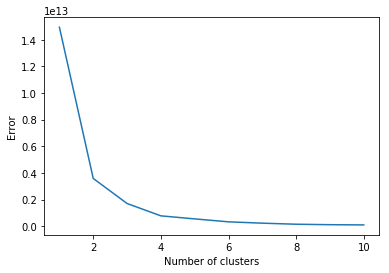

In [15]:
# X_scale = preprocessing.normalize(df_minimal_columns, norm='l2')
evaluate_clusters(df_minimal_columns.fillna(0),10)
plt.show()

In [16]:
from sklearn.cluster import KMeans

#INTEGER FOR RANDOM SEEDING 
random_state = 170

n_clusters = 3

y_pred = KMeans(n_clusters=n_clusters, init='k-means++',random_state=random_state).fit_predict(df_minimal_columns)
cluster_labels = y_pred

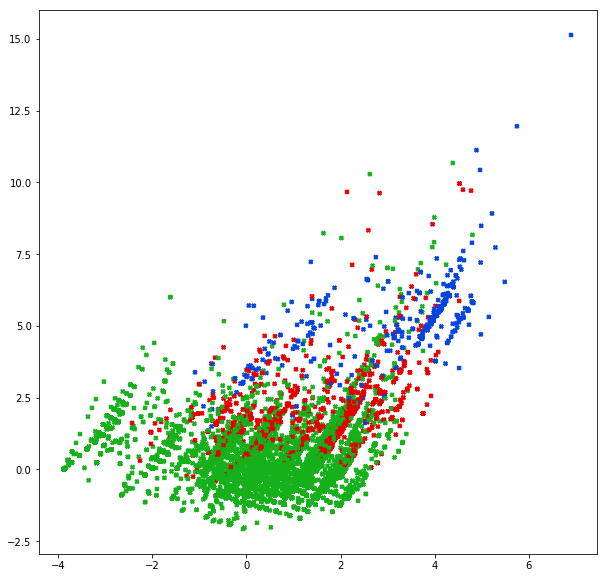

In [17]:
plt.figure(figsize=[10,10])
#vis_x_filtered = vis_x[]
color_mapping = {0: sns.xkcd_rgb['green'], 1: sns.xkcd_rgb['red'], 2: sns.xkcd_rgb['blue'], 3: sns.xkcd_rgb['yellow'], 4: sns.xkcd_rgb['grey']}
colors = list(map(lambda x: color_mapping[x], cluster_labels))
plt.scatter(
        pca_result[:,0],
        pca_result[:,1],
        s=16,
        marker="X",
        c = colors
        )

In [18]:
df_minimal_columns['cluster_label'] =  cluster_labels

## Find key characteristics of these clusters
- top features which are different in the given cluster when compared with the rest of the clusters
- select those specific features to explain the characteristics of the clusters

In [19]:
from sklearn.feature_selection import SelectPercentile,f_classif
from sklearn.model_selection import train_test_split


def get_top_features_from_dataset(data, cluster_labels,n_clusters=3):

    temp_labels = []
    dataset = data.as_matrix()
    labels = set(cluster_labels)
    for label in labels:
        revised_labels = pd.Series(cluster_labels)        
        revised_labels = revised_labels.apply(lambda x: 1 if x == label else 0)
        
        X_train, X_test, y_train, y_test = train_test_split(dataset, revised_labels.as_matrix(),random_state=0,test_size=1)
        fscore = f_classif(X_train,y_train)

        top_feature_set = {
            "cluster_label": str(label),
            "names" : list(data.columns.values),
            "scores" : fscore[0].tolist(),
            "pvalues" : fscore[1].tolist()               
        }    
    
        temp_labels.append(top_feature_set)

    return temp_labels

In [20]:
for result in get_top_features_from_dataset(df_minimal_columns, cluster_labels,n_clusters):
    #Get top values of pvalues
    top_5_p_values_indices = np.argsort(result['pvalues'])[0:10]
    cluster_df = df_minimal_columns[df_minimal_columns['cluster_label'] == int(result['cluster_label'])]
    
    print("\n\nCluster : %s"%str(result['cluster_label']))
    print("-------")
    print("Mean crashes: %1.5f" % df.target.loc[cluster_df.index].mean())
    print("Characteristics of cluster %s"%str(result['cluster_label']))
    
    tmp_df = pd.DataFrame(columns=['feature_name','mean in cluster','mean (overall)','proportion ratio'])
    
    for index in range(len(df_minimal_columns.columns)):
        name = result['names'][index]
        tmp_df= tmp_df.append({
            'feature_name': name  ,
            'mean in cluster': cluster_df[name].mean() ,
            'mean (overall)': df_minimal_columns[name].mean(),
            'proportion ratio': cluster_df[name].mean() / df_minimal_columns[name].mean()
        },ignore_index=True)

        
    print(tmp_df.to_string(index=False))
    



Cluster : 0
-------
Mean crashes: 0.20778
Characteristics of cluster 0
feature_name  mean in cluster  mean (overall)  proportion ratio
         AADT      3032.397657     8470.289801          0.358004
   SPEEDLIMIT        21.811836       23.010917          0.947891
   Struct_Cnd         1.583821        1.601212          0.989139
   Surface_Tp         4.691615        4.772669          0.983017
    F_F_Class         5.358282        5.336497          1.004082
   visionzero         0.364281        0.409660          0.889228
     Conflict        24.947246       30.550996          0.816577
 intersection         0.327953        0.350711          0.935110
cluster_label         0.000000        0.083055          0.000000


Cluster : 1
-------
Mean crashes: 0.34646
Characteristics of cluster 1
feature_name  mean in cluster  mean (overall)  proportion ratio
         AADT     55670.958661     8470.289801          6.572498
   SPEEDLIMIT        34.699803       23.010917          1.507971
   Struct_C

In [21]:
df_minimal_columns['seg_id'] = df['segment_id']

In [22]:
df_minimal_columns.head()

,AADT,SPEEDLIMIT,Struct_Cnd,Surface_Tp,F_F_Class,visionzero,Conflict,intersection,cluster_label,seg_id
0,18330,20,2,6,7,0,0.0,1,0,0
1,0,15,1,6,7,0,0.0,0,0,0
2,22222,20,2,6,3,0,0.0,0,0,1
3,8974,35,1,6,3,2,0.0,0,0,10
4,0,35,2,6,7,1,0.0,0,0,100


In [23]:
preds = pd.read_json('preds_viz.geojson')
preds.head()

,features,type
0,"{'type': 'Feature', 'geometry': {'type': 'Mult...",FeatureCollection
1,"{'type': 'Feature', 'geometry': {'type': 'Line...",FeatureCollection
2,"{'type': 'Feature', 'geometry': {'type': 'Line...",FeatureCollection
3,"{'type': 'Feature', 'geometry': {'type': 'Line...",FeatureCollection
4,"{'type': 'Feature', 'geometry': {'type': 'Line...",FeatureCollection


In [24]:
# Parse features column above into its own df since its nested
feature_data = json_normalize(preds['features'])
feature_data.head(3)

,geometry.coordinates,geometry.type,properties.AADT,properties.Conflict,properties.F_F_Class,properties.F_F_Class0,properties.F_F_Class1,properties.F_F_Class2,properties.F_F_Class3,properties.F_F_Class4,...,properties.width52,properties.width59,properties.width6,properties.width61,properties.width7,properties.width76,properties.width8,properties.width9,properties.width_per_lane,type
0,"[[[-71.12963776439491, 42.232608718040694], [-...",MultiLineString,18330,0.0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,Feature
1,"[[-71.03254854072208, 42.369082347621244], [-7...",LineString,0,0.0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,Feature
2,"[[-71.06858489229529, 42.35165031396928], [-71...",LineString,22222,0.0,3,0,0,0,1,0,...,0,0,0,0,0,0,0,0,15,Feature


In [25]:
feature_data['properties.segment_id'] = feature_data['properties.segment_id'].apply(lambda x: x.lstrip("0"))
feature_data['properties.segment_id'] = feature_data['properties.segment_id'].apply(lambda x: '0' if len(x) == 0 else x)
feature_data['properties.segment_id']

0            0
1            0
2            1
3           10
4          100
5         1000
6        10000
7        10001
8        10002
9        10003
10       10004
11       10005
12       10006
13       10007
14       10008
15       10009
16        1001
17       10010
18       10011
19       10012
20       10013
21       10014
22       10015
23       10016
24       10017
25       10018
26       10019
27        1002
28       10020
29       10021
         ...  
22413      972
22414      973
22415      974
22416      975
22417      976
22418      977
22419      978
22420      979
22421       98
22422      980
22423      981
22424      982
22425      983
22426      984
22427      985
22428      986
22429      987
22430      988
22431      989
22432       99
22433      990
22434      991
22435      992
22436      993
22437      994
22438      995
22439      996
22440      997
22441      998
22442      999
Name: properties.segment_id, Length: 22443, dtype: object

In [26]:
feature_data['properties.segment_id'] = feature_data['properties.segment_id'].apply(lambda x: np.int64(x))


In [27]:
copy = feature_data.copy()
labelled = df_minimal_columns.copy()
copy = copy.merge(labelled, how='left',right_on='seg_id',left_on='properties.segment_id')
copy.head()

,geometry.coordinates,geometry.type,properties.AADT,properties.Conflict,properties.F_F_Class,properties.F_F_Class0,properties.F_F_Class1,properties.F_F_Class2,properties.F_F_Class3,properties.F_F_Class4,...,AADT,SPEEDLIMIT,Struct_Cnd,Surface_Tp,F_F_Class,visionzero,Conflict,intersection,cluster_label,seg_id
0,"[[[-71.12963776439491, 42.232608718040694], [-...",MultiLineString,18330,0.0,7,0,0,0,0,0,...,18330,20,2,6,7,0,0.0,1,0,0
1,"[[[-71.12963776439491, 42.232608718040694], [-...",MultiLineString,18330,0.0,7,0,0,0,0,0,...,0,15,1,6,7,0,0.0,0,0,0
2,"[[-71.03254854072208, 42.369082347621244], [-7...",LineString,0,0.0,7,0,0,0,0,0,...,18330,20,2,6,7,0,0.0,1,0,0
3,"[[-71.03254854072208, 42.369082347621244], [-7...",LineString,0,0.0,7,0,0,0,0,0,...,0,15,1,6,7,0,0.0,0,0,0
4,"[[-71.06858489229529, 42.35165031396928], [-71...",LineString,22222,0.0,3,0,0,0,1,0,...,22222,20,2,6,3,0,0.0,0,0,1


In [28]:
preds['cluster_label'] = copy['cluster_label']
preds.head()

,features,type,cluster_label
0,"{'type': 'Feature', 'geometry': {'type': 'Mult...",FeatureCollection,0
1,"{'type': 'Feature', 'geometry': {'type': 'Line...",FeatureCollection,0
2,"{'type': 'Feature', 'geometry': {'type': 'Line...",FeatureCollection,0
3,"{'type': 'Feature', 'geometry': {'type': 'Line...",FeatureCollection,0
4,"{'type': 'Feature', 'geometry': {'type': 'Line...",FeatureCollection,0


In [29]:
preds['cluster_label'].value_counts()

0    21003
1     1016
2      424
Name: cluster_label, dtype: int64